### Airbnb Popularity Prediction

A regression problem of predicting reviews_per_month, as a proxy for the popularity of the listing with New York City Airbnb listings from 2019 dataset. Airbnb could use this sort of model to predict how popular future listings might be before they are posted, perhaps to help guide hosts create more appealing listings. In reality they might instead use something like vacancy rate or average rating as their target, but we do not have that available here.

#### Importing Libraries

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge

from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    train_test_split,
)

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LassoCV
from xgboost import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
from catboost import CatBoostRegressor

%matplotlib inline

#### Data Preprocessing

In [2]:
airbnb_df = pd.read_csv("AB_NYC_2019.csv")
airbnb_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [4]:
# Removing rows where 'reviews_per_month' value is NA

airbnb_df = airbnb_df[airbnb_df['reviews_per_month'].notna()]

In [5]:
# Handling the NA Values present in `name` column

airbnb_df = airbnb_df[airbnb_df['name'].notna()]

In [6]:
# Changing few feature names to more readable and informative names

airbnb_df = airbnb_df.rename(columns={'name': 'listing_name', 'availability_365':'num_days_available', 'price' : 'listing_price'})

In [7]:
# We now have a total of 38837 rows and none of the columns have any NA values (except host_name which we will be dropping)

airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38837 entries, 0 to 48852
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              38837 non-null  int64  
 1   listing_name                    38837 non-null  object 
 2   host_id                         38837 non-null  int64  
 3   host_name                       38821 non-null  object 
 4   neighbourhood_group             38837 non-null  object 
 5   neighbourhood                   38837 non-null  object 
 6   latitude                        38837 non-null  float64
 7   longitude                       38837 non-null  float64
 8   room_type                       38837 non-null  object 
 9   listing_price                   38837 non-null  int64  
 10  minimum_nights                  38837 non-null  int64  
 11  number_of_reviews               38837 non-null  int64  
 12  last_review                     

#### Data Splitting

In [8]:
train_df, test_df = train_test_split(airbnb_df, test_size=0.3, random_state=123)

In [9]:
train_df.shape

(27185, 16)

In [10]:
test_df.shape

(11652, 16)

### Exploratory Data Analysis (EDA)

In [11]:
# Summary Statistics

train_df.describe(include = 'all')

,id,listing_name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,listing_price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,num_days_available
count,2.718500e+04,27185,2.718500e+04,27179,27185,27185,27185.000000,27185.000000,27185,27185.000000,27185.000000,27185.000000,27185,27185.000000,27185.00000,27185.000000
unique,NaN,26893,NaN,7974,5,217,NaN,NaN,3,NaN,NaN,NaN,1689,NaN,NaN,NaN
top,NaN,Home away from home,NaN,Michael,Manhattan,Williamsburg,NaN,NaN,Entire home/apt,NaN,NaN,NaN,2019-06-23,NaN,NaN,NaN
freq,NaN,10,NaN,230,11566,2226,NaN,NaN,14215,NaN,NaN,NaN,979,NaN,NaN,NaN
mean,1.796071e+07,NaN,6.369945e+07,NaN,NaN,NaN,40.728101,-73.950882,NaN,141.340887,5.888799,29.458819,NaN,1.370237,5.05389,115.108736
std,1.070756e+07,NaN,7.568369e+07,NaN,NaN,NaN,0.054997,0.046970,NaN,189.356695,16.826136,48.264551,NaN,1.690512,25.85398,129.422655
min,2.539000e+03,NaN,2.787000e+03,NaN,NaN,NaN,40.506410,-74.239860,NaN,0.000000,1.000000,1.000000,NaN,0.010000,1.00000,0.000000
25%,8.549497e+06,NaN,6.947307e+06,NaN,NaN,NaN,40.688630,-73.982310,NaN,69.000000,1.000000,3.000000,NaN,0.190000,1.00000,0.000000
50%,1.866950e+07,NaN,2.784491e+07,NaN,NaN,NaN,40.721770,-73.954670,NaN,102.000000,2.000000,10.000000,NaN,0.710000,1.00000,56.000000
75%,2.746893e+07,NaN,1.007843e+08,NaN,NaN,NaN,40.763010,-73.934770,NaN,170.000000,4.000000,34.000000,NaN,2.000000,2.00000,230.000000


**Reasoning**

As we can see from the Summary statistics above, the **mean** of all the numeric columns have a large variation so it is probably a good idea to apply the StandardScaler transformation on the numeric columns.
Also, in the `listing_name` column above we can see that there are many **unique** values so it might be a good idea to apply Count Vectorizer transformation on that column.

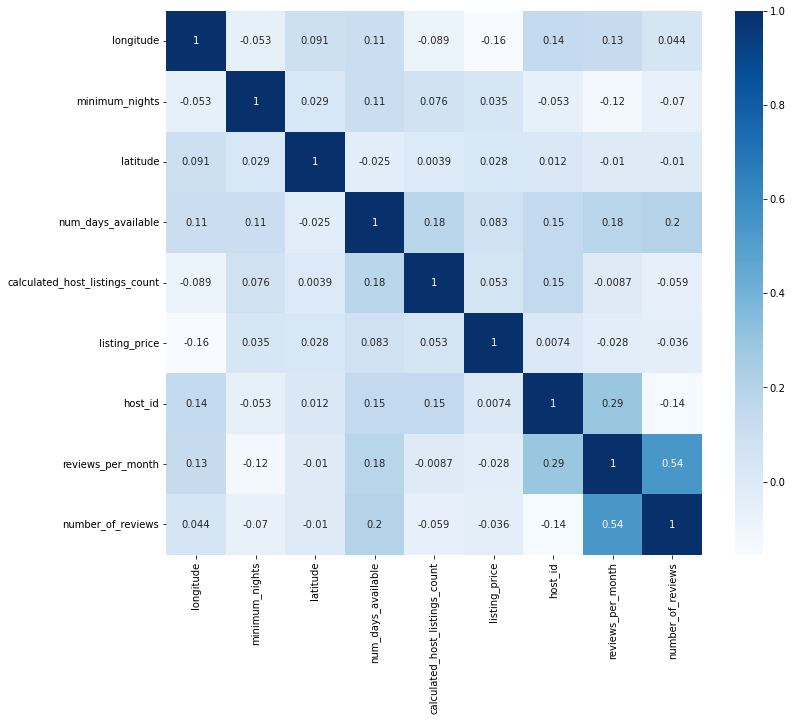

In [12]:
# Correlation of different features in our dataset

features = ['longitude',
 'minimum_nights',
 'latitude',
 'num_days_available',
 'calculated_host_listings_count',
 'listing_price',
 'host_id',
'reviews_per_month',
'number_of_reviews']

cor = train_df[features].corr()
cor

import seaborn as sns
plt.figure(figsize=(12, 10))
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

**Reasoning**

From the correlation plot above, we can see that the columns `longitude`, `host_id` and `num_days_available` are positively correlated to our target column `reviews_per_month`. The column `calculated_host_listings_count` has a small and negative correlation to our target column. The column `minimum_nights` has a comparatively small magnitude and negative correlation to the target column. Based on the above observations, we can see that the column `number_of_reviews` is strongly correlated to our target column and it would not be fair to consider that column because in usual deployment scenraios, we don't have access to the number of reviews of an airbnb and are expected to find the reviews_per_month without those details.

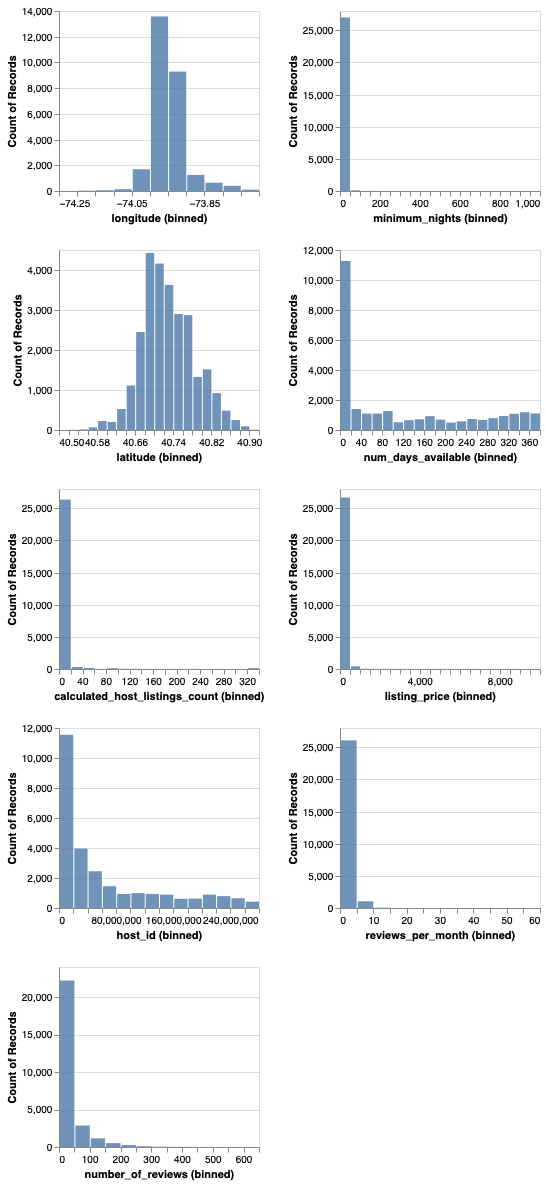

In [13]:
# Visualization of different numeric features using histograms

import altair as alt
from altair_data_server import data_server

alt.data_transformers.enable("data_server")
alt.renderers.enable('mimetype')

features = ['longitude',
 'minimum_nights',
 'latitude',
 'num_days_available',
 'calculated_host_listings_count',
 'listing_price',
 'host_id',
'reviews_per_month',
'number_of_reviews']

features_plot = alt.Chart(train_df).mark_bar(opacity = 0.8).encode(
    x = alt.X(alt.repeat(), type="quantitative", bin = alt.Bin(maxbins=25)),
    y = "count()").properties(width = 200, height = 180).repeat(repeat = features, columns =2)
features_plot

**Reasoning**

From the plots above, we can see that most of the features are skewed and hence we would need to scale all the features to be able to use them as part of our model.

**Analysis of EDA**

As per our EDA, we can see that there are many numeric columns that need to be scaled, so we can apply StandardScaler() transformation on those columns. We also can see that there are many unique values of `listing_name`, so it makes sense to apply CountVectorizer transformation on it. Also, as discussed above we would be dropping `number_of_reviews` as it does not make sense to have that data since that column would never be available to us in real world. We would also be dropping columns like `id` and `host_name` as these columns would not add any value in our predictions.

#### Feature Engineering

In [15]:
# Creating a new feature called last_review_interval

import datetime

train_df["last_review"] = pd.to_datetime(train_df.last_review)
train_df["last_review_interval"] = ((datetime.datetime(2019,12,31) - train_df.last_review)/ np.timedelta64(1, 'D')).astype(int)
test_df["last_review"] = pd.to_datetime(test_df.last_review)
test_df["last_review_interval"] = ((datetime.datetime(2019,12,31) - test_df.last_review)/ np.timedelta64(1, 'D')).astype(int)

**Reasoning**

We are creating the above column to be able to find the interval between the last review date and the last date of the year 2019. This new column would allow us to understand how long before end 2019 was the last review of the listing as this could have an impact on the prediction.

In [16]:
# Creating a new feature called last_review_year

train_df['last_review_year'] = pd.DatetimeIndex(train_df['last_review']).year
test_df['last_review_year'] = pd.DatetimeIndex(test_df['last_review']).year

**Reasoning**

The above column created is to fetch the year of the last review date as we can't process the last_review_date as time series in our data.

In [17]:
train_df.head()

,id,listing_name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,listing_price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,num_days_available,last_review_interval,last_review_year
36716,29183047,Amber Bedroom,119669058,Melissa,Brooklyn,Bedford-Stuyvesant,40.69290,-73.95513,Private room,49,2,15,2019-06-24,1.70,34,306,190,2019
770,276317,"The Carlton, Brooklyn brownstone Duplex w/ garden",130901,Chauncey,Brooklyn,Prospect Heights,40.67847,-73.97038,Entire home/apt,402,3,89,2019-06-23,0.97,1,340,191,2019
38049,30059328,Two Blocks from Washington Square Park!!,41194120,Melissa,Manhattan,Greenwich Village,40.72978,-73.99982,Entire home/apt,275,1,4,2019-05-26,0.61,1,0,219,2019
31860,24857291,新一处客居(New place 1),187908645,Jimmy,Queens,Flushing,40.75582,-73.83215,Private room,60,1,9,2019-01-29,0.69,4,57,336,2019
24543,19737908,Cozy Zen-like Jungle in Bushwick,67271745,Anna,Brooklyn,Bushwick,40.69393,-73.90898,Private room,55,1,1,2017-07-30,0.04,1,0,884,2017


### Preprocessing and transformations